# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Rotations" data-toc-modified-id="Rotations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rotations</a></div><div class="lev1 toc-item"><a href="#PCA" data-toc-modified-id="PCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PCA</a></div><div class="lev1 toc-item"><a href="#FastFourier-Transformation" data-toc-modified-id="FastFourier-Transformation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>FastFourier Transformation</a></div><div class="lev1 toc-item"><a href="#Save-python-object-with-pickle" data-toc-modified-id="Save-python-object-with-pickle-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save python object with pickle</a></div><div class="lev1 toc-item"><a href="#Progress-Bar" data-toc-modified-id="Progress-Bar-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Progress Bar</a></div><div class="lev1 toc-item"><a href="#Check-separations-by-histogram-and-scatter-plot" data-toc-modified-id="Check-separations-by-histogram-and-scatter-plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Check separations by histogram and scatter plot</a></div><div class="lev1 toc-item"><a href="#Plot-Cumulative-Lift" data-toc-modified-id="Plot-Cumulative-Lift-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot Cumulative Lift</a></div><div class="lev1 toc-item"><a href="#GBM-skitlearn" data-toc-modified-id="GBM-skitlearn-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>GBM skitlearn</a></div><div class="lev1 toc-item"><a href="#Xgboost" data-toc-modified-id="Xgboost-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Xgboost</a></div><div class="lev1 toc-item"><a href="#LightGBM" data-toc-modified-id="LightGBM-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>LightGBM</a></div><div class="lev1 toc-item"><a href="#Control-plots:-ROC,-Precision-Recall,-ConfusionMatrix,-top_k,-classification-report," data-toc-modified-id="Control-plots:-ROC,-Precision-Recall,-ConfusionMatrix,-top_k,-classification-report,-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Control plots: ROC, Precision-Recall, ConfusionMatrix, top_k, classification report,</a></div><div class="lev1 toc-item"><a href="#Tuning-parameters-of-a-model" data-toc-modified-id="Tuning-parameters-of-a-model-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Tuning parameters of a model</a></div><div class="lev2 toc-item"><a href="#Grid-search-with-skitlearn" data-toc-modified-id="Grid-search-with-skitlearn-121"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Grid search with skitlearn</a></div><div class="lev2 toc-item"><a href="#Random-search-with-skitlearn" data-toc-modified-id="Random-search-with-skitlearn-122"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>Random search with skitlearn</a></div><div class="lev2 toc-item"><a href="#Bayesian-Optimization--Search" data-toc-modified-id="Bayesian-Optimization--Search-123"><span class="toc-item-num">12.3&nbsp;&nbsp;</span>Bayesian Optimization  Search</a></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv("iris.csv")

# Rotations

In [3]:
def rotMat3D(a,r):
    """Return the matrix that rotate the a vector into the r vector. numpy array are required"""
    
    a = a/np.linalg.norm(a)
    r = r/np.linalg.norm(r)
    
    I = np.eye(3)
    v = np.cross(a,r)
    c = np.inner(a,r)
    v_x = np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])
    
    return I + v_x + np.matmul(v_x,v_x)/(1+c)

In [4]:
# example usage
z_old = np.array([0, 0, 1])
z = np.array([1, 1, 1])
R = rotMat3D(z, z_old)

print(z, R.dot(z))
print(z_old, R.dot(z_old))
print(np.linalg.norm(z), np.linalg.norm(R.dot(z)))

[1 1 1] [ -1.11022302e-16  -1.11022302e-16   1.73205081e+00]
[0 0 1] [-0.57735027 -0.57735027  0.57735027]
1.73205080757 1.73205080757


In [5]:
def createR2D(vector):
    """rotate the vector to [0,1], require numpy array"""
    m = np.linalg.norm(vector)
    c, s = vector[1]/m , vector[0]/m
    R2 = np.array([c, -s, s, c]).reshape(2,2)
    return R2

In [6]:
# example usage
y_old = np.array([3,4])
R2 = createR2D(y_old)

print(y_old, R2.dot(y_old))

[3 4] [  4.44089210e-16   5.00000000e+00]


# PCA

In [9]:
from sklearn import decomposition

def pca_decomposition(df):
    """Perform sklearn PCA. The returned components are already ordered by the explained variance"""
    pca = decomposition.PCA()
    pca.fit(df)
    return pca

def pca_stats(pca):
    print("variance explained:\n", pca.explained_variance_ratio_)
    print("pca components:\n", pca.components_)

def plot_classcolor(df, x='y', y='x', hue=None):
    sns.lmplot(x, y, data=df, hue=hue, fit_reg=False)
    sns.plt.title("({} vs {})".format(y, x))    
    plt.show()

def add_pca_to_df(df, allvars, pca):
    df[["pca_" + str(i) for i, j in enumerate(pca.components_)
        ]] = pd.DataFrame(pca.fit_transform(df[allvars]))

In [10]:
pca = pca_decomposition( df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] )

In [11]:
pca_stats(pca)

variance explained:
 [ 0.92461621  0.05301557  0.01718514  0.00518309]
pca components:
 [[ 0.36158968 -0.08226889  0.85657211  0.35884393]
 [ 0.65653988  0.72971237 -0.1757674  -0.07470647]
 [-0.58099728  0.59641809  0.07252408  0.54906091]
 [ 0.31725455 -0.32409435 -0.47971899  0.75112056]]


In [12]:
add_pca_to_df(df, ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], pca)

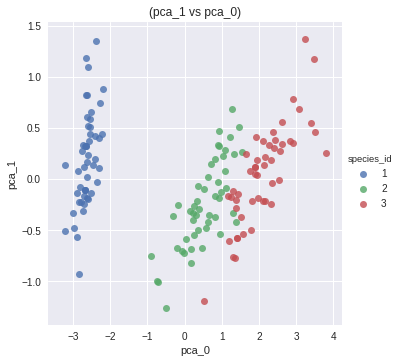

In [13]:
plot_classcolor(df, 'pca_0', 'pca_1', 'species_id')

# FastFourier Transformation

In [25]:
from scipy.fftpack import fft, rfft, irfft, fftfreq
def rfourier_transformation(df, var, pass_high=-1, pass_low=-1, verbose=True, plot=True):
    """Return the signal after low and high filter applied.
    Use verbose and plot to see stats and plot the signal before and after the filter.
    """
    low = pass_high
    high = pass_low
    
    if (high < low) and (high>0):
        print("Cannot be pass_low < pass_high!!")
        return -1

    time = pd.Series(df.index.values[1:10] -
                     df.index.values[:10 - 1])  # using the first 10 data
    dt = time.describe()['50%']
    if (verbose):
        print("""
          sampling time: {0} s
          sampling frequency: {1} hz
          max freq in rfft: {2} hz
          """.format(dt, 1 / dt, 1 / (dt * 2), 1 / (dt)))

    signal = df[var]
    freq = fftfreq(signal.size, d=dt)
    f_signal = rfft(signal)

    m = {}
    if (low > 0):
        f_signal_lowcut = f_signal.copy()
        f_signal_lowcut[(freq < low)] = 0
        cutted_signal_low = irfft(f_signal_lowcut)
        m['low'] = 1

    if (high > 0):
        f_signal_highcut = f_signal.copy()
        f_signal_highcut[(freq > high)] = 0
        cutted_signal_high = irfft(f_signal_highcut)
        m['high'] = 1

    if (high > 0) & (low > 0):
        f_signal_bwcut = f_signal.copy()
        f_signal_bwcut[(freq < low) | (freq > high)] = 0
        cutted_signal_bw = irfft(f_signal_bwcut)
        m['bw'] = 1
        m['low'] = 2
        m['high'] = 3

    n = len(freq)

    if (plot):
        f, axarr = plt.subplots(len(m) + 1, 1, sharex=True, figsize=(18,15))
        f.canvas.set_window_title(var)
    
        # time plot
        axarr[0].plot(signal)
        axarr[0].set_title('Signal')
        if 'bw' in m:
            axarr[m['bw']].plot(df.index, cutted_signal_bw)
            axarr[m['bw']].set_title('Signal after low-high cut')
        if 'low' in m:
            axarr[m['low']].plot(df.index, cutted_signal_low)
            axarr[m['low']].set_title('Signal after high filter (low frequencies rejected)')
        if 'high' in m:
            axarr[m['high']].plot(df.index, cutted_signal_high)
            axarr[m['high']].set_title('Signal after low filter (high frequencies rejected)')
        plt.show()
        
        # spectrum
        f = plt.figure(figsize=(18,8))
        plt.plot(freq[0:n // 2], f_signal[:n // 2])
        f.suptitle('Frequency spectrum')
        if 'low' in m:
            plt.axvline(x=low, ymin=0., ymax=1, linewidth=2, color='red')
        if 'high' in m:
            plt.axvline(x=high, ymin=0., ymax=1, linewidth=2, color='red')
        plt.show()
    
    if 'bw' in m:
        return cutted_signal_bw
    elif 'low' in m:
        return cutted_signal_low
    elif 'high' in m:
        return cutted_signal_high
    else:
        return signal


          sampling time: 1.0 s
          sampling frequency: 1.0 hz
          max freq in rfft: 0.5 hz
          


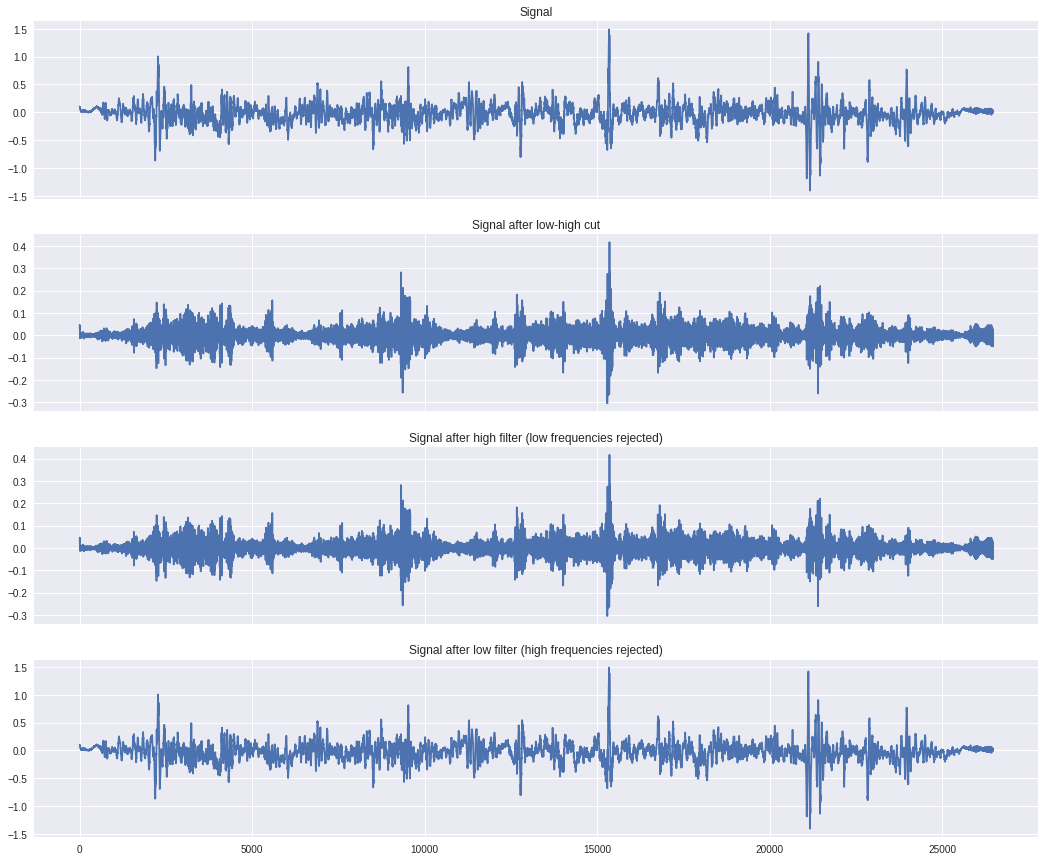

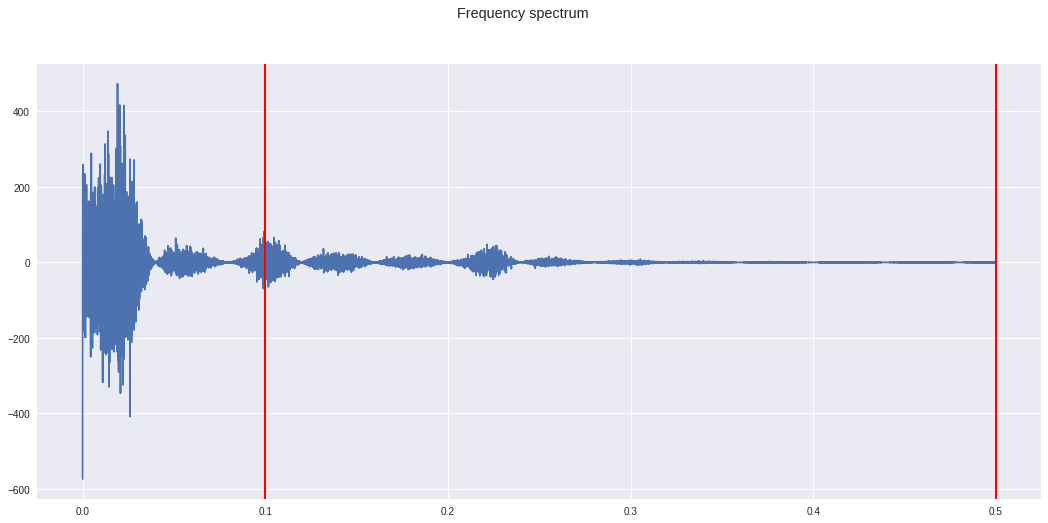

In [24]:
acc = pd.read_csv('accelerations.csv')
signal = rfourier_transformation(acc, 'x', pass_high=0.1, pass_low=0.5, verbose=True, plot=True)

# Save python object with pickle

In [2]:
# save in pickle with gzip compression
import pickle
import gzip


def save(obj, filename, protocol=0):
    file = gzip.GzipFile(filename, 'wb')
    file.write(pickle.dumps(obj, protocol))
    file.close()


def load(filename):
    file = gzip.GzipFile(filename, 'rb')
    buffer = ""
    while True:
        data = file.read()
        if data == "":
            break
        buffer += data
    obj = pickle.loads(buffer)
    file.close()
    return obj

# Progress Bar
There are many packages to create a progress bar in python, the one I use is tqdm
- tqdm: https://pypi.python.org/pypi/tqdm 

others are:
- progressbar: with each iterable (mainly for) https://pypi.python.org/pypi/progressbar2
- https://github.com/niltonvolpato/python-progressbar

In [3]:
# Simple bar, the one to be used in a general python code
import tqdm
import time
for i in tqdm.tqdm(range(0, 1000)):
    pass

100%|██████████| 1000/1000 [00:00<00:00, 1923992.66it/s]


In [4]:
# Bar to be used in a jupyter notebook
for i in tqdm.tqdm_notebook(range(0, 1000)):
    pass

In [5]:
# custom update bar
tot = 4000
bar = tqdm.tqdm_notebook(desc='Status ', total=tot, mininterval=0.5, miniters=5, unit='cm', unit_scale=True)
# with the file options you can show the progress bar into a file
# mininterval: time in seconds to see an update on the progressbar. tqdm always gets updated in the background, but it will diplay only every mininterval.
# miniters: Tweak this and `mininterval` to get very efficient loops, if 0 will only use mininterval
# unit_scale: use international scale for the units (k, M, m, etc...)
# bar_format: specify the bar format, default is '{l_bar}{bar}{r_bar}'. It can impact the performance if you ask for complicate bar format
# unit_divisor: [default: 1000], ignored unless `unit_scale` is True
# ncols: The width of the entire output message. If specified, dynamically resizes the progressbar to stay within this bound.

for l in range(0, tot):
    if ((l-1) % 10) == 0:
        bar.update(10)
    if l % 1000 == 0:
        bar.write('to print something without duplicate the progress bar (if you are using tqdm.tqdm instead of tqdm.tqdm_notebook)')
        print('or use the simple print if you are using tqdm.tqdm_notebook')
    time.sleep(0.001)

to print something without duplicate the progress bar (if you are using tqdm.tqdm instead of tqdm.tqdm_notebook)
or use the simple print if you are using tqdm.tqdm_notebook
to print something without duplicate the progress bar (if you are using tqdm.tqdm instead of tqdm.tqdm_notebook)
or use the simple print if you are using tqdm.tqdm_notebook
to print something without duplicate the progress bar (if you are using tqdm.tqdm instead of tqdm.tqdm_notebook)
or use the simple print if you are using tqdm.tqdm_notebook
to print something without duplicate the progress bar (if you are using tqdm.tqdm instead of tqdm.tqdm_notebook)
or use the simple print if you are using tqdm.tqdm_notebook


In [31]:
# Some text from web page to don't slow your code and keep the progressbar with the right printing frequency

# mininterval is more intuitive to configure than miniters. 
# clever adjustment system dynamic_miniters will automatically adjust miniters to the amount of iterations that fit into time mininterval.
# Essentially, tqdm will check if it’s time to print without actually checking time. This behavior can be still be bypassed by manually setting miniters.

# However, consider a case with a combination of fast and slow iterations. After a few fast iterations, dynamic_miniters will set miniters to a large number. 
# When interation rate subsequently slows, miniters will remain large and thus reduce display update frequency. To address this:
# maxinterval defines the maximum time between display refreshes. A concurrent monitoring thread checks for overdue updates and forces one where necessary.

In [6]:
# you can use tqdm as bash command too (e.g. for compression/decompression of a file, cut, sed, awk operations etc...)
!seq 9999999 | tqdm --unit_scale | wc -l

10.0Mit [00:05, 1.92Mit/s]
9999999


In [7]:
# use trange instead of range, it's faster with progressbar
for i in tqdm.trange(100):
    pass

100%|██████████| 100/100 [00:00<00:00, 223220.01it/s]


4000/|/100%|| 4.00K/4.00K [00:20<00:00, 876cm/s]

In [26]:
# use tqdm.tnrange instead of trange in jupyter notebook
for i in tqdm.tnrange(100):
    pass

In [17]:
# change the prefix and postfix of the bar during executions
from random import random, randint

t = tqdm.trange(100)
for i in t:
    # Description will be displayed on the left
    t.set_description('GEN %i' % i)
    # Postfix will be displayed on the right, and will format automatically based on argument's datatype
    t.set_postfix(loss=random(), gen=randint(1,999), str='h', lst=[1, 2])
    time.sleep(0.1)

GEN 99: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s, gen=161, loss=0.856, lst=[1, 2], str=h] 


In [25]:
# nested progress bar
for i in tqdm.tnrange(3, desc='first progressbar'):
    for j in tqdm.tnrange(20, desc='\tsecond progressbar', leave=True):
        sleep(0.05)

In [9]:
# with this extension you can use tqdm_notebook().pandas(...) instead of tqdm.pandas(...)
from tqdm import tqdm_notebook
!jupyter nbextension enable --py --sys-prefix widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [12]:
# pandas apply & groupby operations with progressbar (tqdm state that it will not noticeably slow pandas down)
import pandas as pd
import numpy as np
df = pd.DataFrame(np.random.randint(0, int(1e8), (100, 3)))

# Create and register a new `tqdm` instance with `pandas`
# (can use tqdm_gui, optional kwargs, etc.)
print('set tqdm_notebook for pandas, show the bar')
tqdm_notebook().pandas()
# Now you can use `progress_apply` instead of `apply`


print('example usage of progressbar in a groupby pandas statement')
df_g = df.groupby(0).progress_apply(lambda x: time.sleep(0.01))


print('example usage of progressbar in an apply pandas statement')
df_a = df.progress_apply(lambda x: time.sleep(0.01))

set tqdm_notebook for pandas, show the bar


example usage of progressbar in a groupby pandas statement


example usage of progressbar in an apply pandas statement


# Check separations by histogram and scatter plot

In [1]:
def plot_classcolor(df, x='y', y='x', hue=None):
    sns.lmplot(x, y, data=df, hue=hue, fit_reg=False)
    sns.plt.title("({} vs {})".format(y, x))    
    plt.show()

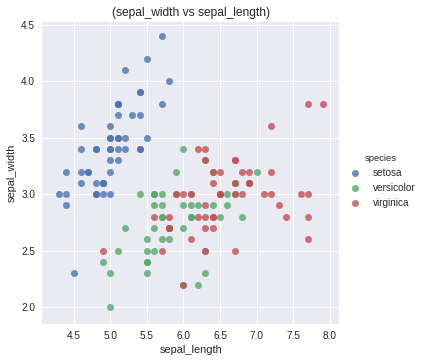

In [7]:
plot_classcolor(df, 'sepal_length', 'sepal_width', hue='species')

In [219]:
def plot_histo_per_class(df, var, target):
    t_list = df[target].unique()
    for t in t_list:
        sns.distplot(
            df[df[target] == t][var], kde=False, norm_hist=True, label=str(t))
    sns.plt.legend()
    sns.plt.show()

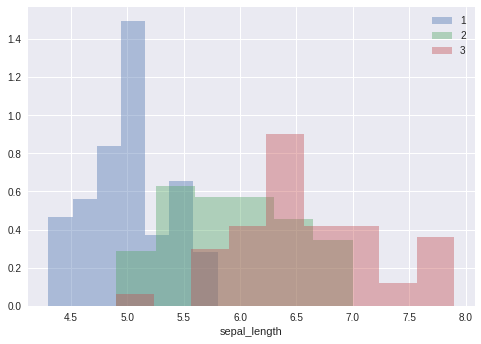

In [133]:
plot_histo_per_class(df, 'sepal_length', "species_id")

# Plot Cumulative Lift

In [249]:
def plotLift(df, features, target, ascending=False, multiclass_level=None):
    """
    Plot the Lift function for all the features.
    Ascending can be a list of the same feature length or a single boolean value.
    For the multiclass case you can give the value of a class and the lift is calculated
    considering the select class vs all the other
    """
    if multiclass_level != None:
        df = df[features+[target]].copy()
        if multiclass_level != 0:
            df.loc[df[target] != multiclass_level, target] = 0
            df.loc[df[target] == multiclass_level, target] = 1
        else :
            df.loc[df[target] == multiclass_level, target] = 1      
            df.loc[df[target] != multiclass_level, target] = 0
        
    npoints = 100
    n = len(df)
    st = n / npoints
    df_shuffled = df.sample(frac=1)

    flat = np.array([[(i * st) / n, df_shuffled[0:int(i * st)][target].sum()]
                     for i in range(1, npoints + 1)])
    flat = flat.transpose()
    to_leg = []

    if not isinstance(features, list):
        features = [features]
    if not isinstance(ascending, list):
        ascending = [ascending for i in features]

    for f, asc in zip(features, ascending):
        a = df[[f, target]].sort_values(f, ascending=asc)
        b = np.array([[(i * st) / n, a[0:int(i * st)][target].sum()]
                      for i in range(1, npoints + 1)])
        b = b.transpose()
        to_leg.append(plt.plot(b[0], b[1], label=f)[0])
    to_leg.append(plt.plot(flat[0], flat[1], label="no_gain")[0])
    plt.legend(handles=to_leg, loc=4)
    plt.xlabel('faction of data', fontsize=18)
    plt.ylabel(target+' (cumulative sum)', fontsize=16)

    plt.show()

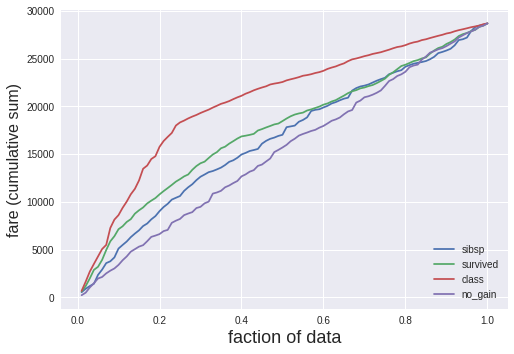

In [250]:
# Lift for regression
titanic = sns.load_dataset("titanic")
plotLift(titanic, ['sibsp', 'survived', 'class'], 'fare', ascending=[False,False, True])

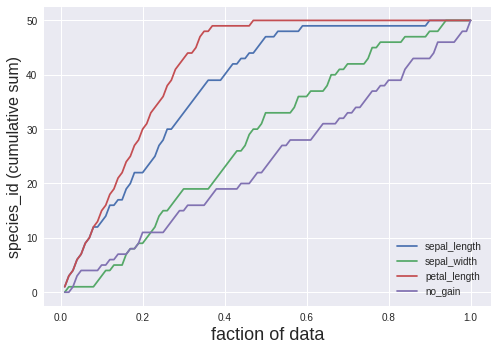

In [253]:
# Lift plot example for multiclass
plotLift(
    df, ['sepal_length', 'sepal_width', 'petal_length'],
    'species_id',
    ascending=[False, True, False],
    multiclass_level=3)

# GBM skitlearn

In [ ]:
def plot_var_imp_skitlearn(features, clf_fit):
    """Plot var_imp for a skitlearn fitted model"""
    my_ff = np.array(features)
    importances = clf_fit.feature_importances_
    indices = np.argsort(importances)
    pos = np.arange(len(my_ff[indices])) + .5
    plt.figure(figsize=(20, 0.75 * len(my_ff[indices])))
    plt.barh(pos, importances[indices], align='center')
    plt.yticks(pos, my_ff[indices], size=25)
    plt.xlabel('rank')
    plt.title('Feature importances', size=25)
    plt.grid(True)
    plt.show()
    importance_dict = dict(zip(my_ff[indices], importances[indices]))
    return importance_dict

# Xgboost
To instal xgboost: https://github.com/dmlc/xgboost/tree/master/python-package
- conda install py-xgboost (pip install xgboost)

In [2]:
import xgboost

/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
#### VERSIONE GIUSTA A LAVORO

def plot_var_imp_xgboost(model, mode='gain', ntop=-1):
    """Plot the vars imp for xgboost model, where mode = ['weight','gain','cover']  
    'weight' - the number of times a feature is used to split the data across all trees.
    'gain' - the average gain of the feature when it is used in trees
    'cover' - the average coverage of the feature when it is used in trees
    """
    importance = model.get_score(importance_type=mode)
    importance = sorted(
        importance.items(), key=operator.itemgetter(1), reverse=True)
    if ntop == -1: ntop = len(importance)
    importance = importance[0:ntop]
    my_ff = np.array([i[0] for i in importance])
    imp = np.array([i[1] for i in importance])
    indices = np.argsort(imp)
    pos = np.arange(len(my_ff[indices])) + .5
    plt.figure(figsize=(20, 0.75 * len(my_ff[indices])))
    plt.barh(pos, imp[indices], align='center')
    plt.yticks(pos, my_ff[indices], size=25)
    plt.xlabel('rank')
    plt.title('Feature importances (' + mode + ')', size=25)
    plt.grid(True)
    plt.show()
    return

# LightGBM
New way to install the package:
- pip install lightgbm


Old way to install the package
- build the package from https://github.com/Microsoft/LightGBM/wiki/Installation-Guide
- add the library to python using: python setup.py install inside the python package of the github clone

Problem: when you compile a package with the linux compiler and then you use it with the anaconda compiler you need to have the same compiler on both.

This cannot be the default and to fix this do:
- cd ~/anaconda3/lib
- mv -vf libstdc++.so.6 libstdc++.so.6.old
- ln -s /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ./libstdc++.so.6

So now the shared library seen from anaconda is the same that have been usage when the package was compiled.
These steps were necessary to install lightgbm

In [4]:
import lightgbm as lgb

# Control plots: ROC, Precision-Recall, ConfusionMatrix, top_k, classification report, 

In [12]:
### VERSIONE CORRETTA A LAVORO

def plot_ROC_PrecisionRecall(y_test, y_pred):
    """
    Plot ROC curve and Precision-Recall plot
    numpy arrays are required. 
    """
    fpr_clf, tpr_clf, _ = roc_curve(y_test, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    f1 = np.array([2 * p * r / (p + r) for p, r in zip(precision, recall)])
    f1[np.isnan(f1)] = 0
    t_best_f1 = thresholds[np.argmax(f1)]
    roc_auc = auc(fpr_clf, tpr_clf)
    plt.figure(figsize=(25, 25))
    # plot_ROC
    plt.subplot(221)
    plt.plot(
        fpr_clf,
        tpr_clf,
        color='r',
        lw=2,
        label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    # plot_PrecisionRecall
    plt.subplot(222)
    plt.plot(
        recall, precision, color='r', lw=2, label='Precision-Recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precison-Recall curve')
    plt.legend(loc="lower right")

    plt.show()
    return {"roc_auc": roc_auc, "t_best_f1": t_best_f1}


def plot_ROC_PR_test_train(y_train, y_test, y_test_pred, y_train_pred):
    """Plot ROC and Precision-Recall curve for test and train.
    Return the auc for test and train"""
    roc_auc_test = plot_ROC_PrecisionRecall(y_test, y_test_pred)
    roc_auc_train = plot_ROC_PrecisionRecall(y_train, y_train_pred)
    return roc_auc_test, roc_auc_train

# Tuning parameters of a model

## Grid search with skitlearn

## Random search with skitlearn

## Bayesian Optimization  Search

- https://github.com/fmfn/BayesianOptimization
- use params, pars to pass the different parameters to the train function.
- try to make it without xgboost or with other things in general or a simple example

In [ ]:
### Bayesian Optimization
# https://github.com/fmfn/BayesianOptimization
from bayes_opt import BayesianOptimization

def xgb_evaluate_gen(xg_train, xg_test, watchlist, num_rounds):
    """Create the function to be optimized (example for xgboost)"""
    params = { 'eta': 0.1, 'objective':'binary:logistic','silent': 1, 'eval_metric': 'auc' }
    
    def xgb_evaluate(min_child_weight,colsample_bytree,max_depth,subsample,gamma,alpha):
        """ Return the function to be maximized by the Bayesian Optimization,
        where the inputs are the parameters to be optimized and the output the 
        evaluation_metric on test set"""
        params['min_child_weight'] = int(round(min_child_weight))
        params['cosample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['subsample'] = max(min(subsample, 1), 0)
        params['gamma'] = max(gamma, 0)
        params['alpha'] = max(alpha, 0)
        #cv_result = xgb.cv(params, xg_train, num_boost_round=num_rounds, nfold=5, 
        #                   seed=random_state, callbacks=[xgb.callback.early_stop(25)]
        model_temp = xgb.train(params, dtrain=xg_train, num_boost_round=num_rounds, 
                               evals=watchlist, early_stopping_rounds=15, verbose_eval=False)
        # return -cv_result['test-merror-mean'].values[-1]
        return float(str(model_temp.eval(xg_test)).split(":")[1][0:-1])
    
    return xgb_evaluate

    
def go_with_BayesianOptimization(xg_train, xg_test, watchlist, num_rounds = 1, 
                                 num_iter = 10, init_points = 10, acq='ucb'):
    """Send the Batesian Optimization for xgboost. acq = 'ucb', 'ei', 'poi' """
    xgb_func = xgb_evaluate_gen(xg_train, xg_test, watchlist, num_rounds)
    xgbBO = BayesianOptimization(xgb_func, {'min_child_weight': (1, 50),
                                            'colsample_bytree': (0.5, 1),
                                            'max_depth': (5, 15),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 2),
                                            'alpha': (0, 2),
                                            })
    xgbBO.maximize(init_points=init_points, n_iter=num_iter, acq=acq) # poi, ei, ucb    
